In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import tensorflow as tf
from keras import metrics
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/h1-indice/w1h.csv


In [2]:
df = pd.read_csv('/kaggle/input/h1-indice/w1h.csv')
df

,Unnamed: 0,time,open,high,low,close,tick_volume,spread,real_volume
0,0,2017-10-13 09:00:00,77085.0,77555.0,76990.0,77350.0,55603,5,196682
1,1,2017-10-13 10:00:00,77345.0,77485.0,77140.0,77250.0,67446,5,236072
2,2,2017-10-13 11:00:00,77250.0,77305.0,76835.0,76895.0,69548,5,276329
3,3,2017-10-13 12:00:00,76905.0,77120.0,76820.0,77105.0,39742,5,168288
4,4,2017-10-13 13:00:00,77105.0,77150.0,76855.0,76985.0,31165,5,122360
...,...,...,...,...,...,...,...,...,...
11641,11641,2022-10-28 16:00:00,115930.0,115990.0,115605.0,115940.0,428811,5,1573295
11642,11642,2022-10-28 17:00:00,115940.0,117100.0,115905.0,117045.0,476947,5,1427925
11643,11643,2022-10-31 09:00:00,113000.0,114140.0,112500.0,113410.0,967012,5,2443323
11644,11644,2022-10-31 10:00:00,113410.0,118135.0,113355.0,117690.0,1301594,5,3910708


### Retirada de colunas e a ultima linha

In [3]:
df = df.drop(df.columns[[0,3,4,6,7,8]],axis=1)
df

,time,open,close
0,2017-10-13 09:00:00,77085.0,77350.0
1,2017-10-13 10:00:00,77345.0,77250.0
2,2017-10-13 11:00:00,77250.0,76895.0
3,2017-10-13 12:00:00,76905.0,77105.0
4,2017-10-13 13:00:00,77105.0,76985.0
...,...,...,...
11641,2022-10-28 16:00:00,115930.0,115940.0
11642,2022-10-28 17:00:00,115940.0,117045.0
11643,2022-10-31 09:00:00,113000.0,113410.0
11644,2022-10-31 10:00:00,113410.0,117690.0


### Adicionando features ao modelo como médias móveis, RSI, Hora e indicador de gap.

In [4]:
df['media_9'] = df['close'].ewm(9).mean().shift()
df = df.drop(df.index[:21])

def relative_strength_idx(df, n=14):
    close = df['close']  # Use 'close' em vez de 'close'
    delta = close.diff()
    delta = delta.iloc[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)
df = df[df['RSI'].notna() & (df['RSI'] != 0)]

df['time'] = pd.to_datetime(df['time'])

# coluna indicadora de gap
df['gap_indicator'] = ((df['time'].dt.hour >= 18) | (df['time'].dt.hour < 9)).astype(int)
dflist = pd.to_datetime(df['time'])

df

,time,open,close,media_9,RSI,gap_indicator
35,2017-10-18 15:00:00,77215.0,77390.0,76827.852855,67.478261,0
36,2017-10-18 16:00:00,77390.0,77460.0,76885.363185,75.849057,0
37,2017-10-18 17:00:00,77455.0,77380.0,76944.016087,71.314741,0
38,2017-10-18 18:00:00,77390.0,77435.0,76988.424850,74.245473,1
39,2017-10-19 09:00:00,76910.0,76860.0,77033.828030,59.228188,0
...,...,...,...,...,...,...
11641,2022-10-28 16:00:00,115930.0,115940.0,115888.964612,56.777251,0
11642,2022-10-28 17:00:00,115940.0,117045.0,115894.068151,61.058924,0
11643,2022-10-31 09:00:00,113000.0,113410.0,116009.161336,36.568365,0
11644,2022-10-31 10:00:00,113410.0,117690.0,115749.245202,56.564914,0


### Separando coluna time do df e fazendo ajustes no shape

In [5]:
cols = list(df)[1:6]
cols
print('shape_treino == {}'.format(df.shape))
print('All timestamps == {}'.format(len(dflist)))
print('Features: =={}'.format(cols))
df = df[cols].astype(str)

for i in cols:
    for j in range(35, len(df)):
        df[i][j] = df[i][j].replace(',', '')

df = df.astype(float)

# Usando multiplas features
training_set = df.values

print('shape do modelo == {}.'.format(training_set.shape))

shape_treino == (11611, 6)
All timestamps == 11611
Features: ==['open', 'close', 'media_9', 'RSI', 'gap_indicator']
shape do modelo == (11611, 5).


### Normalização dos dados usando StandardScaler, separando as features do target.

In [6]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])
X_train = []
y_train = []

# Numero de linhas no passado usadas para prever o futuro
n_future = 1   
n_past = 200


for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 1]) # target (close)

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (11411, 200, 4).
y_train shape == (11411, 1).


### Usando rede sequencial do Keras e deep learning com 4 camadas.

In [7]:
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_past, df.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=50, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

### treinamento do modelo com uso de callbacks para ajuda a evitar o (overfitting) e a otimizar a convergência do treinamento.

In [8]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')


history = model.fit(X_train, y_train, shuffle=True, epochs=200, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=100)

Epoch 1/200
92/92 [==============================] - ETA: 0s - loss: 0.0424
Epoch 1: val_loss improved from inf to 0.00686, saving model to weights.h5
92/92 [==============================] - 48s 478ms/step - loss: 0.0424 - val_loss: 0.0069 - lr: 0.0100
Epoch 2/200
92/92 [==============================] - ETA: 0s - loss: 0.0141
Epoch 2: val_loss improved from 0.00686 to 0.00239, saving model to weights.h5
92/92 [==============================] - 42s 459ms/step - loss: 0.0141 - val_loss: 0.0024 - lr: 0.0100
Epoch 3/200
92/92 [==============================] - ETA: 0s - loss: 0.0126
Epoch 3: val_loss did not improve from 0.00239
92/92 [==============================] - 42s 462ms/step - loss: 0.0126 - val_loss: 0.0026 - lr: 0.0100
Epoch 4/200
92/92 [==============================] - ETA: 0s - loss: 0.0119
Epoch 4: val_loss improved from 0.00239 to 0.00198, saving model to weights.h5
92/92 [==============================] - 43s 465ms/step - loss: 0.0119 - val_loss: 0.0020 - lr: 0.0100
Epoc

In [9]:
loss = model.evaluate(X_train, y_train, verbose=0)
accuracy = 1.0 / np.sqrt(loss)
print("Acurácia do modelo:", accuracy)

Acurácia do modelo: 21.182002563901992


In [10]:
last_inputs = training_set_scaled[-n_past:, 0:df.shape[1] - 1]

# Redimensionando os últimos dados para ter as mesmas dimensões que o X_train
last_inputs = np.reshape(last_inputs, (1, n_past, df.shape[1] - 1))

# Fazendo a previsão
predicted_scaled = model.predict(last_inputs)

# Invertendo a escala da previsão para obter o valor real
predicted = sc_predict.inverse_transform(predicted_scaled)

print("Previsão do valor de fechamento:", predicted)


1/1 [==============================] - 1s 872ms/step
Previsão do valor de fechamento: [[116887.016]]


7/7 [==============================] - 0s 57ms/step


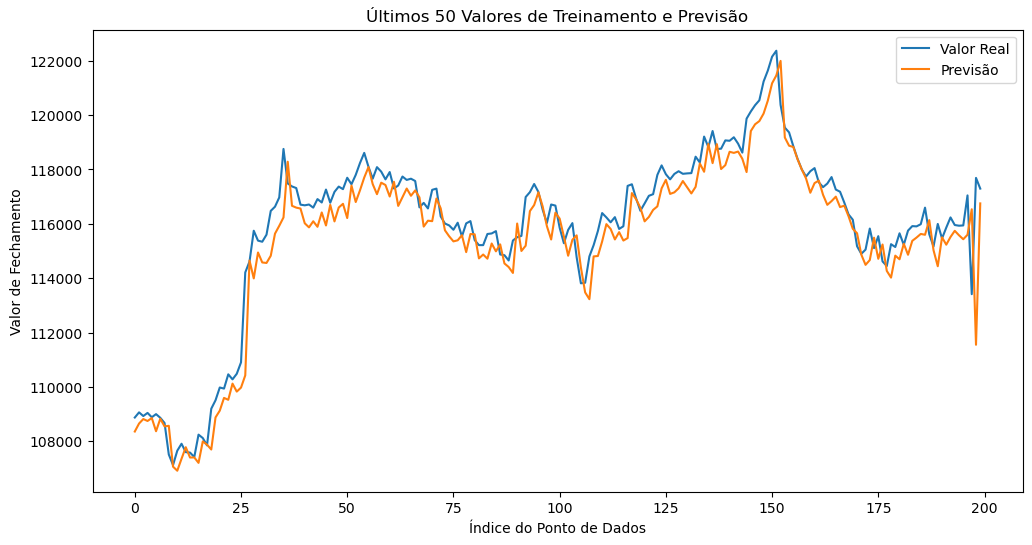

In [11]:
# Inverter a escala dos últimos 50 valores de treinamento reais
y_train_true_last50 = sc_predict.inverse_transform(y_train[-200:])

# Fazer a previsão dos últimos 50 valores usando o modelo
X_train_last50 = X_train[-200:]
y_train_pred_scaled_last50 = model.predict(X_train_last50)
y_train_pred_last50 = sc_predict.inverse_transform(y_train_pred_scaled_last50)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_train_true_last50, label='Valor Real')
plt.plot(y_train_pred_last50, label='Previsão')
plt.title('Últimos 50 Valores de Treinamento e Previsão')
plt.xlabel('Índice do Ponto de Dados')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()